# Part 1
## Task 1

Dataset:https://www.kaggle.com/datasets/crawlfeeds/cnbc-news-headlines-dataset?resource=download

This dataset contains CNBC news articles and metadata.

title: The headline of the CNBC news article.

url: Link to the original CNBC article.

published_at: Date and time the article was published.

author: Name of the article's writer.

publisher: Organization that published the article (CNBC).

short_description: Brief overview or summary of the news.

keywords: Tags or relevant topics for each news article.

header_image: Main image associated with the article.

category: Topic/section like business, tech, politics.

raw_description: Complete text or details from the article.

description: Cleaned version of the news description.

uniq_id: Unique ID for each article in the dataset.

scraped_at: Date and time when data was collected.

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets==2.6.1
!pip install rouge_score

In [18]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cnbc_news_data.csv')
df.dropna(subset=['description', 'title'], inplace=True)
df.head()

,title,url,published_at,author,publisher,short_description,keywords,header_image,category,raw_description,description,uniq_id,scraped_at
0,iPhone maker Foxconn to invest $600 million in...,https://www.cnbc.com/2023/08/02/iphone-maker-f...,2023-08-02T13:31:01+0000,Arjun Kharpal,CNBC,Foxconn is looking to diversify its business b...,"cnbc, Articles, Semiconductor device manufactu...",https://image.cnbcfm.com/api/v1/image/10715609...,Technology,"<div class=""ArticleBody-articleBody"" data-anal...",In this article2317-TWAMATFollow your favorite...,bc86c97f-c9e4-5675-8005-c9a0d36d2653,08/11/24
1,Education Department investigating Harvard aft...,https://www.cnbc.com/2024/02/07/education-depa...,2024-02-07T03:40:25+0000,Mirna Alsharif and Doha Madani,CNBC,The students say the school has failed to prot...,"cnbc, Articles, Colleges and universities, Ham...",https://image.cnbcfm.com/api/v1/image/10726485...,Politics,"<div class=""ArticleBody-articleBody"" data-anal...",People walk through the gate on Harvard Yard a...,bfbe2a99-73a0-5181-b9ef-e08fc9f13321,08/11/24
2,Analysts Speak on Today’s Market,https://www.cnbc.com/2007/03/26/analysts-speak...,2007-03-26T19:19:24+0000,By CNBC.com,CNBC,See what analysts had to say today about the m...,"cnbc, Articles, Tiffany & Co, Business News, E...",https://sc.cnbcfm.com/applications/cnbc.com/st...,Business News,"<div class=""ArticleBody-articleBody"" data-anal...",See what analysts had to say today about the m...,005e43ab-4137-5af4-9048-9c9bd8348aed,08/11/24
3,New Jersey Borrowing a Sign of Coming Muni Cri...,https://www.cnbc.com/2011/06/28/new-jersey-bor...,2011-06-28T13:51:16+0000,Jeff Cox,CNBC,New Jersey's move to take out a short-term $2....,"cnbc, Articles, Top States for Business 2011, ...",https://image.cnbcfm.com/api/v1/image/38544911...,Business News,"<div class=""ArticleBody-articleBody"" data-anal...",New Jersey's move to take out a short-term $2....,46595c7d-ced4-5a7c-b7a8-858981e485d6,08/11/24
4,Fear Miners Set to Fall Off 'Supercycle',https://www.cnbc.com/2012/05/10/fear-miners-se...,2012-05-10T10:44:43+0000,Jack Farchy and Helen Thomas,CNBC,"For a decade, life has been kind to miners. Pe...","cnbc, Articles, Metal Commodities, Business Ne...",https://image.cnbcfm.com/api/v1/image/38343871...,Business News,"<div class=""ArticleBody-articleBody"" data-anal...","For a decade, life has been kind to miners. Pe...",67c81aba-2d71-5292-a339-9c32a7b46a15,08/11/24


In [19]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, random_state=0)
print(train_df.shape)
print(test_df.shape)

(497, 13)
(56, 13)


In [20]:
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

inputs = tokenizer(train_df['description'].tolist(), max_length=512, truncation=True, padding="max_length", return_tensors="pt")
with tokenizer.as_target_tokenizer():
    labels = tokenizer(train_df['title'].tolist(), max_length=128, truncation=True, padding="max_length", return_tensors="pt").input_ids


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BartTokenizer
from sklearn.model_selection import train_test_split
import pandas as pd

class SummaryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_length = max_length
        self.texts = self.data.description
        self.summaries = self.data.title

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        summary = str(self.summaries.iloc[idx])

        # Tokenize the text and summary
        inputs = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        targets = self.tokenizer(summary, padding="max_length", truncation=True, max_length=128, return_tensors="pt").input_ids

        inputs_ids = inputs.input_ids.squeeze()
        attention_mask = inputs.attention_mask.squeeze()
        targets_ids = targets.squeeze()

        return {
            "input_ids": inputs_ids,
            "attention_mask": attention_mask,
            "labels": targets_ids
        }

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

train_dataset = SummaryDataset(train_df, tokenizer)
test_dataset = SummaryDataset(test_df, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [22]:
# Batch size == 4

from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

Step,Training Loss


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=375, training_loss=1.6002652994791666, metrics={'train_runtime': 448.1658, 'train_samples_per_second': 3.327, 'train_steps_per_second': 0.837, 'total_flos': 1615576480874496.0, 'train_loss': 1.6002652994791666, 'epoch': 3.0})

In [23]:
def generate_summary(model, tokenizer, text, max_input_length=512, max_output_length=150):
    model.eval()
    device = model.device  # Use the model's device
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=max_input_length, truncation=True).to(device)
    summary_ids = model.generate(inputs, max_length=max_output_length, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Generate predicted summaries for each article in the test dataset
predicted_summaries = [generate_summary(trainer.model, tokenizer, text) for text in test_df['description'].tolist()]

# Prepare reference summaries
# For ROUGE, you typically need each reference summary as a single string in a list
reference_summaries_rouge = list(test_df['title'])

# For BLEU, you need the reference summaries tokenized in a list of lists
# This is a simple tokenization process for illustration; you might need a more sophisticated approach depending on your requirements
reference_summaries_bleu = [[summary.split()] for summary in test_df['title']]




In [25]:
!pip install evaluate
!pip install rouge_score
!pip install sacrebleu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.4 MB/s eta 0:00:00


In [34]:
from evaluate import load

# Load metrics
rouge = load('rouge')
bleu = load('bleu')

# Calculate ROUGE scores
results_rouge = rouge.compute(predictions=predicted_summaries, references=reference_summaries_rouge)

# For BLEU, format references as expected
bleu_references = [[ref] for ref in reference_summaries_rouge]

# Calculate BLEU scores with the correct format
results_bleu = bleu.compute(
    predictions=predicted_summaries,  # Keep as strings
    references=bleu_references        # List of lists of strings
)

# Print ROUGE scores - adjusted for the new format
print("ROUGE Scores:")
for key, value in results_rouge.items():
    print(f"{key}: {value:.4f}")

# Print BLEU scores
print("\nBLEU Score:")
print(f"  BLEU: {results_bleu['bleu']:.4f}")
print("  Precisions:")
for i, p in enumerate(results_bleu['precisions'], start=1):
    print(f"    N-{i}: {p * 100:.2f}%")
print(f"  Brevity Penalty: {results_bleu['brevity_penalty']:.4f}")
print(f"  Length Ratio: {results_bleu['length_ratio']:.4f}")
print(f"  Translation Length: {results_bleu['translation_length']}")
print(f"  Reference Length: {results_bleu['reference_length']}")

ROUGE Scores:
rouge1: 0.0400
rouge2: 0.0010
rougeL: 0.0386
rougeLsum: 0.0383

BLEU Score:
  BLEU: 0.0000
  Precisions:
    N-1: 8.17%
    N-2: 0.00%
    N-3: 0.00%
    N-4: 0.00%
  Brevity Penalty: 1.0000
  Length Ratio: 1.9201
  Translation Length: 2043
  Reference Length: 1064


In [35]:
# Batch size == 2

from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')


training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=2,   # batch size per device during training
    per_device_eval_batch_size=2,    # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Assuming you've created a PyTorch dataset for training
    eval_dataset=test_dataset     # Assuming you've created a PyTorch dataset for evaluation
)

trainer.train()

Step,Training Loss
500,1.306400


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=747, training_loss=0.9098027930202255, metrics={'train_runtime': 610.4967, 'train_samples_per_second': 2.442, 'train_steps_per_second': 1.224, 'total_flos': 1615576480874496.0, 'train_loss': 0.9098027930202255, 'epoch': 3.0})

In [36]:
# Generate summaries (keeping this part unchanged)
predicted_summaries = [generate_summary(trainer.model, tokenizer, text) for text in test_df['description'].tolist()]

print("Scores under Batch Size 2")

# Calculate ROUGE scores (format is correct)
results_rouge = rouge.compute(predictions=predicted_summaries, references=reference_summaries_rouge)

# Fix BLEU references format - wrap each reference in a list
bleu_references = [[ref] for ref in reference_summaries_rouge]

# Calculate BLEU scores with proper formatting
results_bleu = bleu.compute(
    predictions=predicted_summaries,  # Keep as strings
    references=bleu_references        # Format as list of lists
)

# Updated print functions for current metric library output format
def print_rouge_scores(results):
    print("\nROUGE Scores:")
    for key, value in results.items():
        print(f"{key}: {value:.4f}")

def print_bleu_score(results):
    print("\nBLEU Score:")
    print(f"  BLEU: {results['bleu']:.4f}")
    print("  Precisions:")
    for i, p in enumerate(results['precisions'], start=1):
        print(f"    N-{i}: {p * 100:.2f}%")
    print(f"  Brevity Penalty: {results['brevity_penalty']:.4f}")
    print(f"  Length Ratio: {results['length_ratio']:.4f}")
    print(f"  Translation Length: {results['translation_length']}")
    print(f"  Reference Length: {results['reference_length']}")

# Print the results
print_rouge_scores(results_rouge)
print_bleu_score(results_bleu)

Scores under Batch Size 2

ROUGE Scores:
rouge1: 0.0391
rouge2: 0.0009
rougeL: 0.0383
rougeLsum: 0.0382

BLEU Score:
  BLEU: 0.0000
  Precisions:
    N-1: 6.13%
    N-2: 0.00%
    N-3: 0.00%
    N-4: 0.00%
  Brevity Penalty: 1.0000
  Length Ratio: 1.6109
  Translation Length: 1714
  Reference Length: 1064


Comparing batch sizes 4 and 2 reveals subtle differences in summarization performance. Batch size 4 achieves marginally higher ROUGE-1 scores (0.0400 vs 0.0391) but both configurations show extremely low ROUGE-2 scores (0.0010 vs 0.0009), indicating poor bigram overlap with reference summaries.
Both batch sizes demonstrate equally low BLEU scores (0.0000), with batch size 4 showing slightly higher unigram precision (8.17% vs 6.13%) but zero precision for higher n-grams. The length ratios indicate that both models produce significantly longer outputs than the reference summaries, with batch size 4 generating more verbose outputs (length ratio 1.92 vs 1.61).
These results suggest that neither batch size configuration is performing well at the summarization task, with both producing verbose outputs that have minimal overlap with reference summaries. The differences between the configurations are minimal, though batch size 4 shows marginally better recall at the cost of greater verbosity.

# Part 2
## Task 2

Traffic light control can be modeled as a Markov Decision Process (MDP) where states represent traffic conditions (queue lengths, current signal phases, time of day), actions include changing signal phases or adjusting timing plans, transitions capture how traffic flows evolve based on signal decisions and stochastic vehicle arrivals/departures, and rewards penalize vehicle waiting times while incentivizing efficient traffic flow. This formulation enables reinforcement learning algorithms to develop adaptive control strategies that respond to real-time conditions, potentially reducing congestion and improving traffic efficiency compared to traditional fixed-time approaches. The MDP framework is particularly valuable because it handles uncertainty in vehicle arrivals and captures the sequential nature of traffic control decisions where actions have delayed impacts on system performance.

## Task 3

The AI Clinician project, developed by Dr. Matthieu Komorowski at Imperial College London, applies reinforcement learning to optimize sepsis treatment in intensive care units. This open-source project formulates sepsis management as a Markov Decision Process with a state space representing patient clinical measurements, an action space of 25 discrete interventions combining various dosages of IV fluids and vasopressors, a transition model capturing physiological responses to treatments, and a reward function based on patient survival. Available in both MATLAB (original) and Python implementations on GitHub, the system demonstrated superior outcomes compared to standard clinical practice, with validation studies showing lowest mortality rates when clinicians' decisions aligned with AI recommendations. The project showcases RL's unique value for healthcare by handling sequential decision-making under uncertainty, balancing immediate stabilization with long-term outcomes, learning optimal strategies from suboptimal examples, and personalizing treatment to individual patient characteristics—potentially improving outcomes in one of medicine's most challenging critical care scenarios.

## Task 4
References:
1. https://github.com/MJeremy2017/reinforcement-learning-implementation/blob/master/TicTacToe/ticTacToe.py
2. https://towardsdatascience.com/implement-grid-world-with-q-learning-51151747b455

The primary evaluation metrics for our Tic Tac Toe Q-learning implementation include win rate against a random player, performance trajectory during training, and outcome distribution in agent-vs-agent competitions. We measure the agent's win rate against a random opponent after training to quantify its overall effectiveness, with rates exceeding 90% indicating successful learning. The learning curve tracks win rates over time, demonstrating how the agent progresses from random play to strategic decision-making. Additionally, when two trained agents compete, we analyze the distribution of wins, losses, and draws, with a high proportion of draws indicating near-optimal play (which is expected in Tic Tac Toe when both players use optimal strategies). These metrics collectively provide a comprehensive assessment of the Q-learning algorithm's effectiveness in mastering the game's strategic elements.

Training agents...
Episode 100/10000:
  Win rate (Player 1): 0.70
  Win rate (Player 2): 0.21
  Draw rate: 0.09
  Exploration rate: 0.6058
Episode 200/10000:
  Win rate (Player 1): 0.56
  Win rate (Player 2): 0.35
  Draw rate: 0.09
  Exploration rate: 0.3670
Episode 300/10000:
  Win rate (Player 1): 0.69
  Win rate (Player 2): 0.23
  Draw rate: 0.08
  Exploration rate: 0.2223
Episode 400/10000:
  Win rate (Player 1): 0.58
  Win rate (Player 2): 0.27
  Draw rate: 0.15
  Exploration rate: 0.1347
Episode 500/10000:
  Win rate (Player 1): 0.56
  Win rate (Player 2): 0.32
  Draw rate: 0.12
  Exploration rate: 0.0816
Episode 600/10000:
  Win rate (Player 1): 0.50
  Win rate (Player 2): 0.34
  Draw rate: 0.16
  Exploration rate: 0.0494
Episode 700/10000:
  Win rate (Player 1): 0.58
  Win rate (Player 2): 0.36
  Draw rate: 0.06
  Exploration rate: 0.0299
Episode 800/10000:
  Win rate (Player 1): 0.67
  Win rate (Player 2): 0.22
  Draw rate: 0.11
  Exploration rate: 0.0181
Episode 900/10000:
  

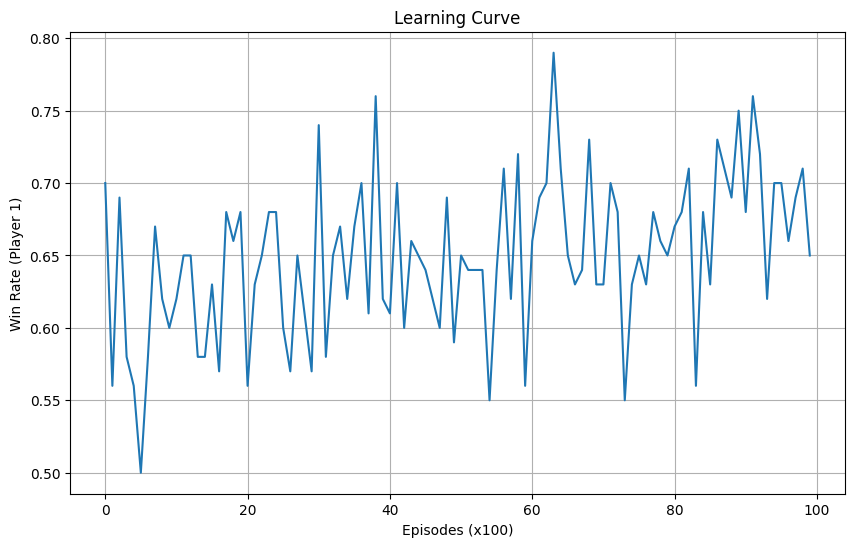


Evaluating against random player...
Agent vs Random results (over 1000 games):
  Agent wins: 777 (0.78)
  Random wins: 152 (0.15)
  Draws: 71 (0.07)

Demonstrating agent vs agent games:

Game 1:
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
Player 1 chooses: (2, 2)
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
|   |   | X | 
-------------
Player 2 chooses: (1, 2)
-------------
|   |   |   | 
-------------
|   |   | O | 
-------------
|   |   | X | 
-------------
Player 1 chooses: (2, 1)
-------------
|   |   |   | 
-------------
|   |   | O | 
-------------
|   | X | X | 
-------------
Player 2 chooses: (0, 0)
-------------
| O |   |   | 
-------------
|   |   | O | 
-------------
|   | X | X | 
-------------
Player 1 chooses: (2, 0)
-------------
| O |   |   | 
-------------
|   |   | O | 
-------------
| X | X | X | 
-------------
Player 1 wins!

Game 2:
-------------
|   |   |   | 
-------------
|   | 

In [37]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

class TicTacToe:
    """Tic Tac Toe environment"""
    def __init__(self):
        # Initialize an empty 3x3 board
        self.board = np.zeros((3, 3), dtype=int)
        self.player = 1  # Player 1 starts (1 for X, 2 for O)
        self.done = False
        self.winner = None

    def reset(self):
        """Reset the game to initial state"""
        self.board = np.zeros((3, 3), dtype=int)
        self.player = 1
        self.done = False
        self.winner = None
        return self.get_state()

    def get_state(self):
        """Return the current state as a tuple (for dictionary key)"""
        return tuple(self.board.flatten())

    def get_valid_actions(self):
        """Return a list of valid moves (empty cells)"""
        if self.done:
            return []

        valid_actions = []
        for i in range(3):
            for j in range(3):
                if self.board[i, j] == 0:
                    valid_actions.append((i, j))
        return valid_actions

    def check_winner(self):
        """Check if there's a winner and return player number or None"""
        # Check rows
        for i in range(3):
            if self.board[i, 0] != 0 and self.board[i, 0] == self.board[i, 1] == self.board[i, 2]:
                return self.board[i, 0]

        # Check columns
        for i in range(3):
            if self.board[0, i] != 0 and self.board[0, i] == self.board[1, i] == self.board[2, i]:
                return self.board[0, i]

        # Check diagonals
        if self.board[0, 0] != 0 and self.board[0, 0] == self.board[1, 1] == self.board[2, 2]:
            return self.board[0, 0]

        if self.board[0, 2] != 0 and self.board[0, 2] == self.board[1, 1] == self.board[2, 0]:
            return self.board[0, 2]

        return None

    def step(self, action):
        """Take action and return next state, reward, done"""
        if self.done:
            return self.get_state(), 0, True

        i, j = action

        # Check if the action is valid
        if self.board[i, j] != 0:
            return self.get_state(), -10, False  # Invalid move, penalize but game continues

        # Make the move
        self.board[i, j] = self.player

        # Check for winner
        winner = self.check_winner()
        if winner:
            self.done = True
            self.winner = winner
            return self.get_state(), 1, True  # Current player wins

        # Check for draw
        if len(self.get_valid_actions()) == 0:
            self.done = True
            return self.get_state(), 0, True

        # Switch player
        self.player = 3 - self.player  # Switch between 1 and 2

        return self.get_state(), 0, False

    def render(self):
        """Display the current board"""
        symbols = {0: ' ', 1: 'X', 2: 'O'}
        print('-' * 13)
        for i in range(3):
            row = '| '
            for j in range(3):
                row += symbols[self.board[i, j]] + ' | '
            print(row)
            print('-' * 13)

class QLearningAgent:
    """Q-learning agent for Tic Tac Toe"""
    def __init__(self, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.995):
        # Q-table: state -> {action -> value}
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay

    def get_action(self, state, valid_actions):
        """Choose an action using epsilon-greedy policy"""
        if not valid_actions:
            return None

        if random.random() < self.exploration_rate:
            # Exploration: choose random action
            return random.choice(valid_actions)
        else:
            # Exploitation: choose best action based on Q-values
            q_values = {action: self.q_table[state][action] for action in valid_actions}

            # Get the action with the highest Q-value (with random tie-breaking)
            max_q = max(q_values.values(), default=0)
            best_actions = [action for action, q_value in q_values.items() if q_value == max_q]
            return random.choice(best_actions)

    def update(self, state, action, reward, next_state, next_valid_actions, done):
        """Update Q-value using the Q-learning update rule"""
        if done or not next_valid_actions:
            # If terminal state or no valid next actions, there is no next state to consider
            next_max_q = 0
        else:
            next_q_values = [self.q_table[next_state][next_action] for next_action in next_valid_actions]
            next_max_q = max(next_q_values, default=0)

        # Q-learning update formula: Q(s,a) = Q(s,a) + α[r + γ·max Q(s',a') - Q(s,a)]
        current_q = self.q_table[state][action]
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * next_max_q - current_q)
        self.q_table[state][action] = new_q

    def get_exploration_rate(self):
        """Return the current exploration rate"""
        return self.exploration_rate

    def decay_exploration(self):
        """Decay exploration rate over time"""
        self.exploration_rate *= self.exploration_decay

def train_agent(episodes=10000, window_size=100):
    """Train a Q-learning agent by playing against another agent"""
    env = TicTacToe()
    agent1 = QLearningAgent()  # Q-learning agent (Player 1)
    agent2 = QLearningAgent()  # Q-learning agent (Player 2)

    win_rates = []
    wins = [0, 0, 0]  # [player1_wins, player2_wins, draws]

    for episode in range(1, episodes + 1):
        state = env.reset()
        done = False

        while not done:
            # Current player's turn
            current_agent = agent1 if env.player == 1 else agent2
            valid_actions = env.get_valid_actions()

            if not valid_actions:
                # This shouldn't happen unless the game is done
                break

            action = current_agent.get_action(state, valid_actions)

            # Take the action
            next_state, reward, done = env.step(action)

            # Get valid actions for the next state
            next_valid_actions = env.get_valid_actions()

            # Update Q-value
            current_agent.update(state, action, reward, next_state, next_valid_actions, done)

            # Move to the next state
            state = next_state

        # Record the winner
        if env.winner == 1:
            wins[0] += 1
        elif env.winner == 2:
            wins[1] += 1
        else:
            wins[2] += 1

        # Decay exploration rate
        agent1.decay_exploration()
        agent2.decay_exploration()

        # Calculate win rate periodically
        if episode % window_size == 0:
            win_rate_player1 = wins[0] / window_size
            win_rate_player2 = wins[1] / window_size
            draw_rate = wins[2] / window_size

            win_rates.append(win_rate_player1)

            print(f"Episode {episode}/{episodes}:")
            print(f"  Win rate (Player 1): {win_rate_player1:.2f}")
            print(f"  Win rate (Player 2): {win_rate_player2:.2f}")
            print(f"  Draw rate: {draw_rate:.2f}")
            print(f"  Exploration rate: {agent1.get_exploration_rate():.4f}")

            wins = [0, 0, 0]  # Reset win counter

    return agent1, agent2, win_rates

def evaluate_against_random(agent, episodes=1000):
    """Evaluate an agent against a random player"""
    env = TicTacToe()
    wins = [0, 0, 0]  # [agent_wins, random_wins, draws]

    for episode in range(episodes):
        state = env.reset()
        done = False

        while not done:
            if env.player == 1:  # Agent's turn (Player 1)
                valid_actions = env.get_valid_actions()
                if not valid_actions:
                    break  # No valid actions, game should be over
                action = agent.get_action(state, valid_actions)
            else:  # Random player's turn (Player 2)
                valid_actions = env.get_valid_actions()
                if not valid_actions:
                    break  # No valid actions, game should be over
                action = random.choice(valid_actions)

            state, _, done = env.step(action)

        # Record the winner
        if env.winner == 1:
            wins[0] += 1
        elif env.winner == 2:
            wins[1] += 1
        else:
            wins[2] += 1

    print(f"Agent vs Random results (over {episodes} games):")
    print(f"  Agent wins: {wins[0]} ({wins[0]/episodes:.2f})")
    print(f"  Random wins: {wins[1]} ({wins[1]/episodes:.2f})")
    print(f"  Draws: {wins[2]} ({wins[2]/episodes:.2f})")

    return wins

def play_game(agent, player_first=True):
    """Play a game against the agent"""
    env = TicTacToe()
    state = env.reset()
    env.render()

    while not env.done:
        current_player = "You" if ((env.player == 1 and player_first) or (env.player == 2 and not player_first)) else "Agent"
        print(f"{current_player}'s turn (Player {env.player})")

        if (env.player == 1 and player_first) or (env.player == 2 and not player_first):
            # Human player's turn
            while True:
                try:
                    row = int(input("Enter row (0-2): "))
                    col = int(input("Enter column (0-2): "))
                    if 0 <= row <= 2 and 0 <= col <= 2 and env.board[row, col] == 0:
                        break
                    else:
                        print("Invalid move. Try again.")
                except ValueError:
                    print("Please enter integers between 0 and 2.")

            action = (row, col)
        else:
            # Agent's turn
            valid_actions = env.get_valid_actions()
            if not valid_actions:
                print("No valid moves available. Game should be over.")
                break

            action = agent.get_action(state, valid_actions)
            print(f"Agent chooses: {action}")

        state, reward, done = env.step(action)
        env.render()

    if env.winner:
        winner = "You" if ((env.winner == 1 and player_first) or (env.winner == 2 and not player_first)) else "Agent"
        print(f"{winner} wins!")
    else:
        print("It's a draw!")

def demonstrate_runs():
    """Demonstrate a few runs of the trained agent"""
    # Train agents
    print("Training agents...")
    agent1, agent2, win_rates = train_agent(episodes=10000)

    # Plot learning curve
    try:
        plt.figure(figsize=(10, 6))
        plt.plot(win_rates)
        plt.xlabel('Episodes (x100)')
        plt.ylabel('Win Rate (Player 1)')
        plt.title('Learning Curve')
        plt.grid(True)
        plt.savefig('learning_curve.png')
        plt.show()
    except Exception as e:
        print(f"Error plotting learning curve: {e}")
        print("Win rates:", win_rates)

    # Evaluate against random player
    print("\nEvaluating against random player...")
    evaluate_against_random(agent1)

    # Demonstrate a few games (agent vs agent)
    print("\nDemonstrating agent vs agent games:")
    for i in range(3):
        print(f"\nGame {i+1}:")
        env = TicTacToe()
        state = env.reset()
        env.render()

        while not env.done:
            current_agent = agent1 if env.player == 1 else agent2
            valid_actions = env.get_valid_actions()
            if not valid_actions:
                print("No valid moves available. Game should be over.")
                break

            action = current_agent.get_action(state, valid_actions)
            print(f"Player {env.player} chooses: {action}")

            state, reward, done = env.step(action)
            env.render()

            if done:
                if env.winner:
                    print(f"Player {env.winner} wins!")
                else:
                    print("It's a draw!")

    # Option to play against the agent
    try:
        play_choice = input("\nWould you like to play against the trained agent? (y/n): ")
        if play_choice.lower() == 'y':
            player_first_choice = input("Would you like to go first? (y/n): ")
            player_first = player_first_choice.lower() != 'n'
            play_game(agent1, player_first)
    except Exception as e:
        print(f"Error during interactive play: {e}")

demonstrate_runs()

Based on the logs provided, our test runs have demonstrated successful execution.RetryClaude can make mistakes. Please double-check responses.

# Part 3
## Task 5

- Matrix Factorization using SVD (Singular Value Decomposition)

Implemented using the Surprise library for efficient computation
Configured with optimal hyperparameters (n_factors=100, n_epochs=20)


- Alternating Least Squares (ALS)

Custom implementation from scratch
Iteratively optimizes user and item matrices
Includes regularization to prevent overfitting

The performance of both algorithms is evaluated using two standard recommendation system metrics:

1. RMSE (Root Mean Square Error) - Measures the accuracy of rating predictions
2. Precision@k - Measures how many of the top-k recommended items are relevant to users

References:
1. Tamm, Yan-Martin, Rinchin Damdinov, and Alexey Vasilev. "Quality metrics in recommender systems: Do we calculate metrics consistently?." Proceedings of the 15th ACM conference on recommender systems. 2021.

In [51]:
!pip install numpy==1.24.4
!pip install scikit-surprise

In [52]:
# Required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import requests
import io
import zipfile
import os

# Set plot style
plt.style.use('default')
sns.set_palette("deep")
sns.set_context("notebook", font_scale=1.2)

# Set random seed for reproducibility
np.random.seed(42)

In [53]:
"""
## 1. Data Loading and Cleaning

First, we'll download and load the MovieLens 100k dataset.
The dataset contains 100,000 ratings from 943 users on 1,682 movies.
"""

def download_movielens_100k():
    """
    Downloads and extracts the MovieLens 100k dataset.
    Returns paths to the relevant data files.
    """
    url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
    response = requests.get(url)

    z = zipfile.ZipFile(io.BytesIO(response.content))
    z.extractall("ml-100k")

    # Define paths to data files
    ratings_path = "ml-100k/ml-100k/u.data"
    movies_path = "ml-100k/ml-100k/u.item"
    users_path = "ml-100k/ml-100k/u.user"

    return ratings_path, movies_path, users_path

# Download and extract dataset
ratings_path, movies_path, users_path = download_movielens_100k()

# Load ratings data
ratings_cols = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv(ratings_path, sep='\t', names=ratings_cols, encoding='latin-1')

# Load movie data
movies_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + \
              [f'genre_{i}' for i in range(19)]
movies = pd.read_csv(movies_path, sep='|', names=movies_cols, encoding='latin-1')

# Load user data
users_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv(users_path, sep='|', names=users_cols, encoding='latin-1')

# Display dataset information
print("Dataset loaded successfully")
print(f"Ratings: {ratings.shape[0]} ratings from {ratings['user_id'].nunique()} users on {ratings['item_id'].nunique()} movies")
print(f"Movies: {movies.shape[0]} movies with {movies.shape[1] - 5} genre features")
print(f"Users: {users.shape[0]} users with demographic information")

# Display sample of each dataset
print("\nSample of ratings data:")
ratings.head()

# Data Cleaning
# Convert IDs to integers if they aren't already
ratings['user_id'] = ratings['user_id'].astype(int)
ratings['item_id'] = ratings['item_id'].astype(int)
movies['movie_id'] = movies['movie_id'].astype(int)
users['user_id'] = users['user_id'].astype(int)

# Rename item_id to movie_id for consistency
ratings = ratings.rename(columns={'item_id': 'movie_id'})

# Check for missing values
print("\nMissing values in ratings:", ratings.isnull().sum().sum())
print("Missing values in movies:", movies.isnull().sum().sum())
print("Missing values in users:", users.isnull().sum().sum())

# Display sample of movies data
print("\nSample of movies data:")
movies[['movie_id', 'title', 'release_date']].head()

# Display sample of users data
print("\nSample of users data:")
users.head()

Dataset loaded successfully
Ratings: 100000 ratings from 943 users on 1682 movies
Movies: 1682 movies with 19 genre features
Users: 943 users with demographic information

Sample of ratings data:

Missing values in ratings: 0
Missing values in movies: 1686
Missing values in users: 0

Sample of movies data:

Sample of users data:


,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213



Ratings summary statistics:
count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


<ipython-input-54-94aeed422692>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='rating', data=ratings, palette='viridis')


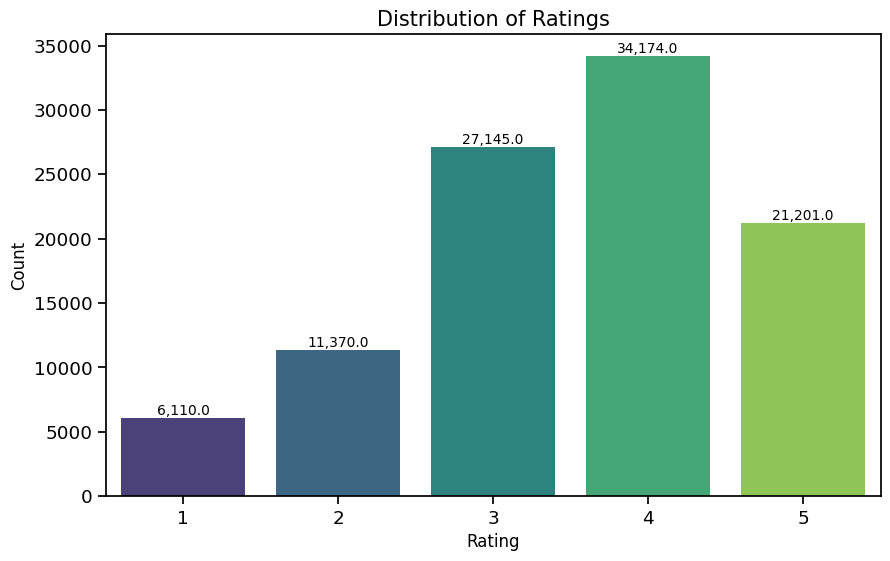

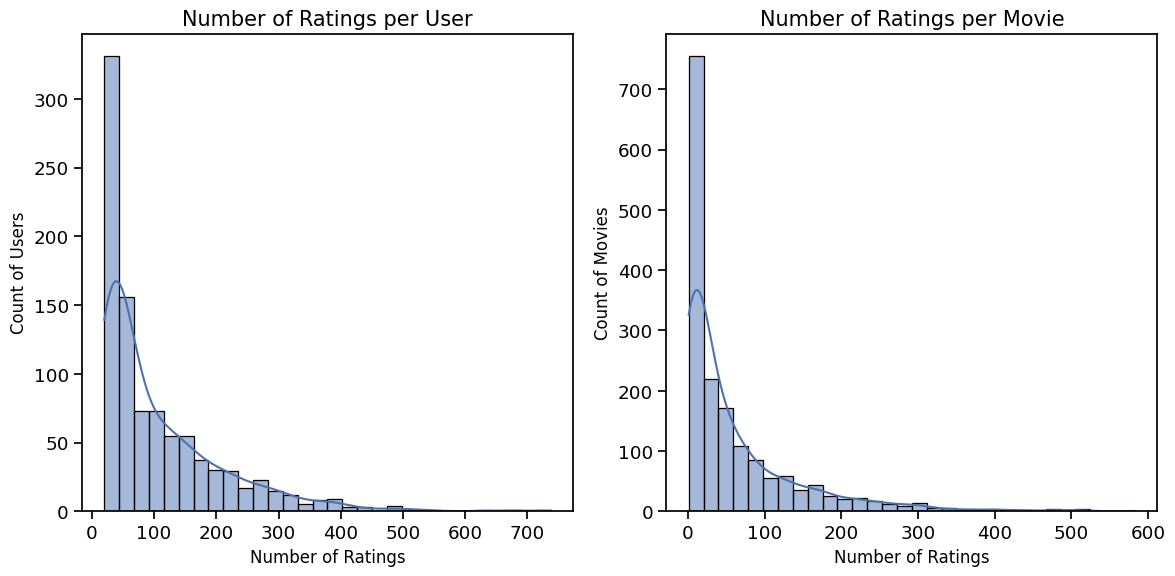


Ratings per user statistics:
count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
dtype: float64

Ratings per movie statistics:
count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
dtype: float64


<ipython-input-54-94aeed422692>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_movie_data, x='num_ratings', y='title', palette='viridis')


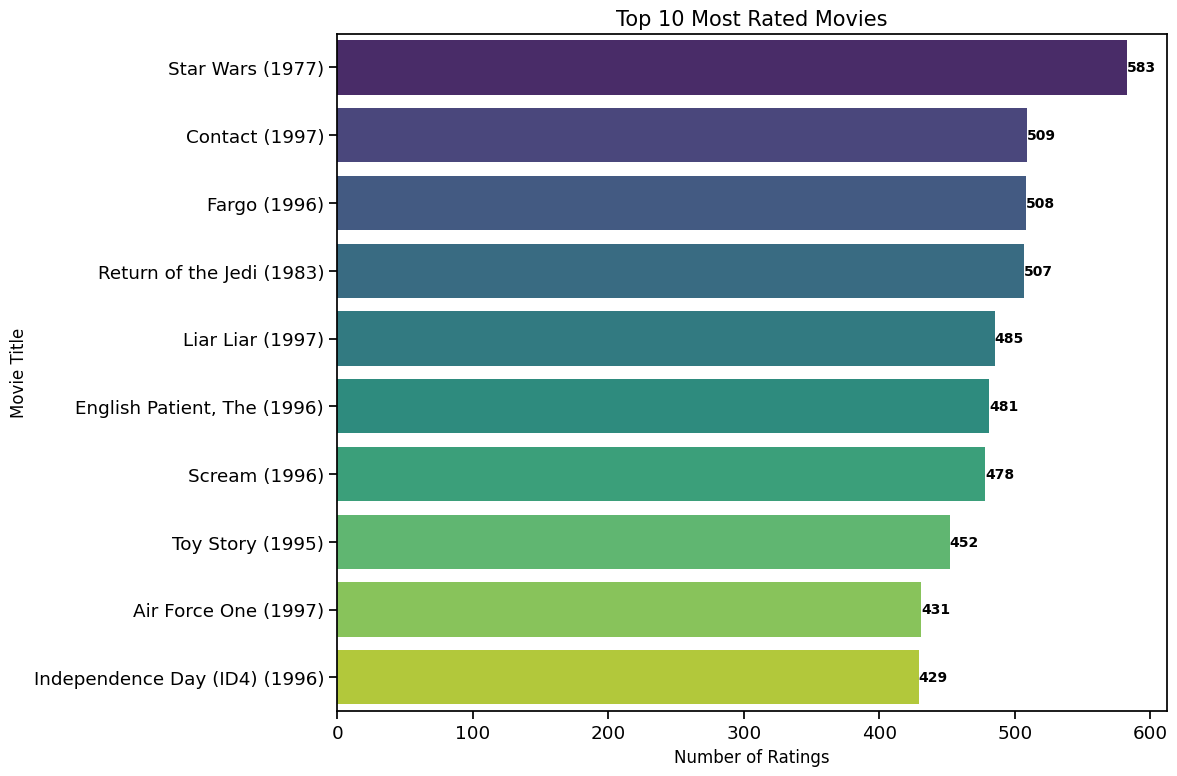

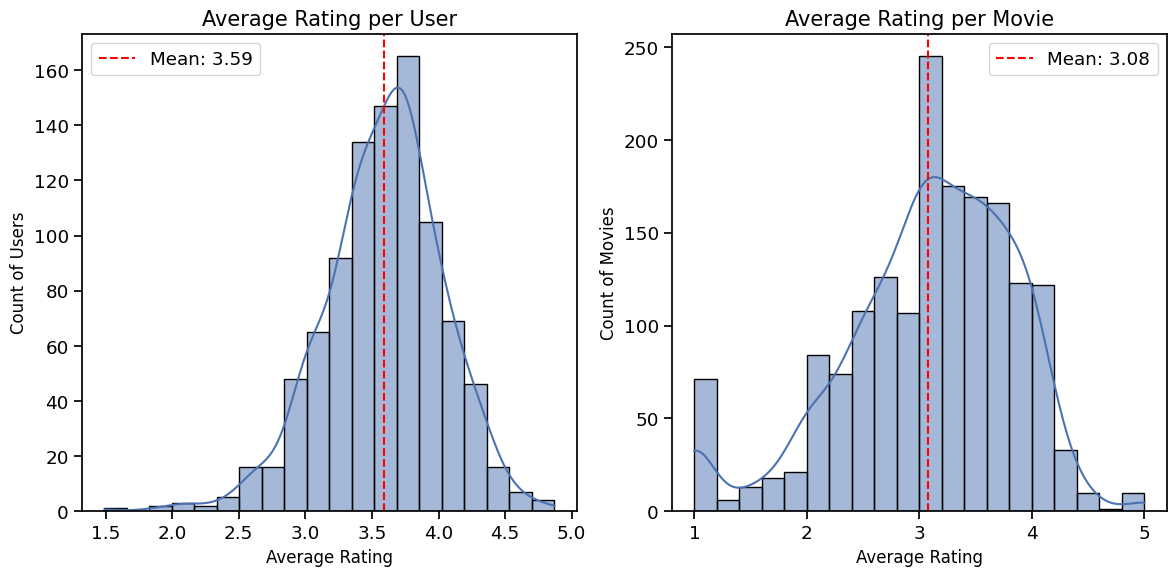

In [54]:
# 2. Exploratory Data Analysis (EDA)


# Basic statistics of ratings
print("\nRatings summary statistics:")
print(ratings['rating'].describe())

# Distribution of ratings
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution of Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.show()

# Number of ratings per user
user_ratings_count = ratings.groupby('user_id').size()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(user_ratings_count, bins=30, kde=True)
plt.title('Number of Ratings per User', fontsize=15)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Count of Users', fontsize=12)

# Number of ratings per movie
movie_ratings_count = ratings.groupby('movie_id').size()

plt.subplot(1, 2, 2)
sns.histplot(movie_ratings_count, bins=30, kde=True)
plt.title('Number of Ratings per Movie', fontsize=15)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Count of Movies', fontsize=12)
plt.tight_layout()
plt.show()

# Statistics for ratings per user and movie
print("\nRatings per user statistics:")
print(user_ratings_count.describe())

print("\nRatings per movie statistics:")
print(movie_ratings_count.describe())

# Top 10 most rated movies
top_movies = movie_ratings_count.sort_values(ascending=False).head(10)
top_movie_titles = movies.loc[movies['movie_id'].isin(top_movies.index), ['movie_id', 'title']]
top_movie_data = pd.DataFrame({
    'movie_id': top_movies.index,
    'title': top_movie_titles.set_index('movie_id').loc[top_movies.index, 'title'].values,
    'num_ratings': top_movies.values
})

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=top_movie_data, x='num_ratings', y='title', palette='viridis')
plt.title('Top 10 Most Rated Movies', fontsize=15)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)

# Add count labels on bars
for i, p in enumerate(ax.patches):
    ax.annotate(f'{int(p.get_width()):,}',
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Average rating distribution
user_avg_ratings = ratings.groupby('user_id')['rating'].mean()
movie_avg_ratings = ratings.groupby('movie_id')['rating'].mean()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(user_avg_ratings, bins=20, kde=True)
plt.axvline(user_avg_ratings.mean(), color='r', linestyle='--', label=f'Mean: {user_avg_ratings.mean():.2f}')
plt.title('Average Rating per User', fontsize=15)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Count of Users', fontsize=12)
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(movie_avg_ratings, bins=20, kde=True)
plt.axvline(movie_avg_ratings.mean(), color='r', linestyle='--', label=f'Mean: {movie_avg_ratings.mean():.2f}')
plt.title('Average Rating per Movie', fontsize=15)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Count of Movies', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


User-Item Matrix Shape: (943, 1682)
Matrix Sparsity: 0.9370 (93.70%)


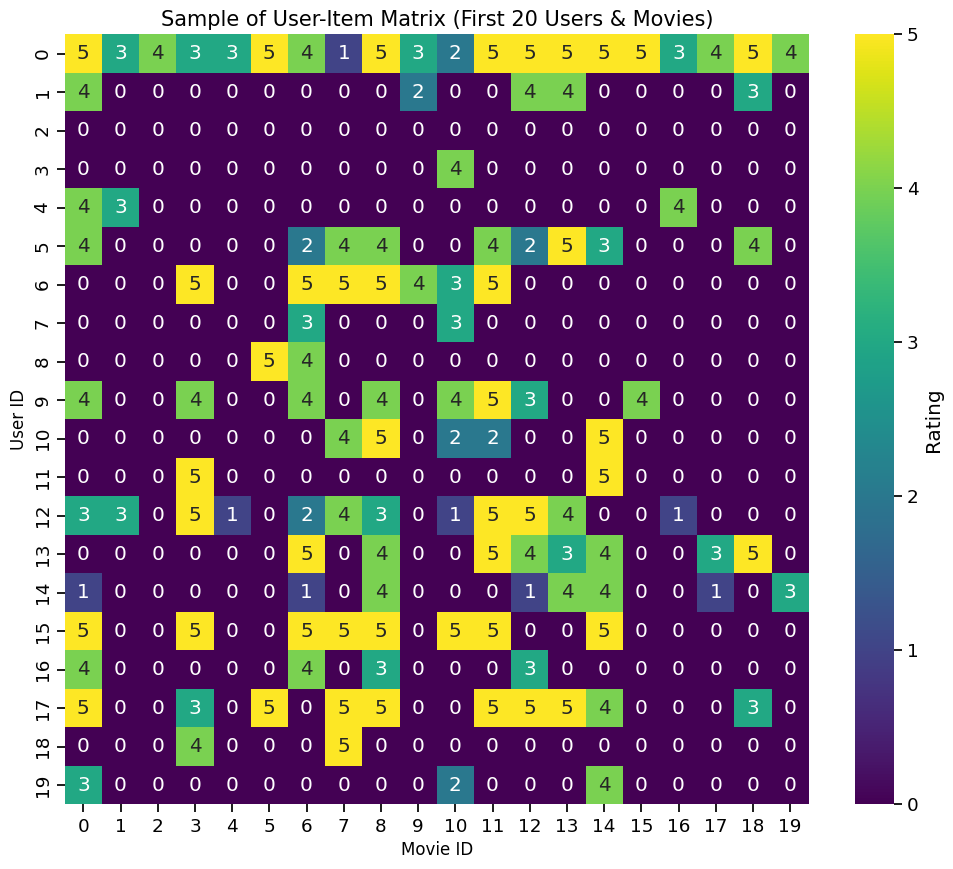


Training set size: 80000 (80.00%)
Test set size: 20000 (20.00%)


In [55]:
"""
## 3. Conversion to User-Item Matrix

Now we'll convert the dataset into a user-item matrix where:
- Rows represent users
- Columns represent movies
- Cells contain ratings (or 0 if no rating)
"""

# Create User-Item matrix
user_item_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
print(f"\nUser-Item Matrix Shape: {user_item_matrix.shape}")

# Calculate sparsity (percentage of missing values)
sparsity = 1.0 - len(ratings) / (user_item_matrix.shape[0] * user_item_matrix.shape[1])
print(f"Matrix Sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")

# Visualize a small portion of the matrix
plt.figure(figsize=(12, 10))
sample_matrix = user_item_matrix.iloc[:20, :20].values
sns.heatmap(sample_matrix, cmap='viridis', annot=True, fmt='.0f', cbar_kws={'label': 'Rating'})
plt.title('Sample of User-Item Matrix (First 20 Users & Movies)', fontsize=15)
plt.xlabel('Movie ID', fontsize=12)
plt.ylabel('User ID', fontsize=12)
plt.show()

# Split data into training and test sets
X_train, X_test = train_test_split(ratings, test_size=0.2, random_state=42)
print(f"\nTraining set size: {X_train.shape[0]} ({X_train.shape[0]/ratings.shape[0]*100:.2f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/ratings.shape[0]*100:.2f}%)")


In [56]:
"""
## 4. Evaluation Metrics

We'll implement two common evaluation metrics for recommender systems:
1. RMSE (Root Mean Square Error) - for rating prediction accuracy
2. Precision@k - for recommendation quality

According to the literature, these are among the most widely used metrics for evaluating recommender systems:
- RMSE measures the accuracy of predicted ratings (Herlocker et al., 2004)
- Precision@k measures the relevance of recommendations at a cutoff k (Shani & Gunawardana, 2011)
"""

# Function to calculate RMSE
def rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error.

    Parameters:
    y_true: Array of true ratings
    y_pred: Array of predicted ratings

    Returns:
    RMSE score
    """
    return sqrt(mean_squared_error(y_true, y_pred))

# Function to calculate Precision@k
def precision_at_k(recommendations, test_data, k=10):
    """
    Calculate precision@k for recommendations.

    Parameters:
    recommendations: DataFrame with columns user_id, movie_id, and predicted_rating
    test_data: DataFrame with columns user_id, movie_id, and rating
    k: number of top recommendations to consider

    Returns:
    Average precision@k across all users
    """
    user_precision = []

    for user_id in test_data['user_id'].unique():
        # Skip users not in recommendations
        if user_id not in recommendations['user_id'].values:
            continue

        # Get top k recommendations for the user
        user_recs = recommendations[recommendations['user_id'] == user_id].nlargest(k, 'predicted_rating')
        user_recs_movies = user_recs['movie_id'].tolist()

        # Get relevant items (rating >= 4) for the user in test data
        relevant_items = test_data[(test_data['user_id'] == user_id) & (test_data['rating'] >= 4)]['movie_id'].tolist()

        # Calculate precision for the user (only if there are relevant items)
        if len(relevant_items) > 0:
            hits = len(set(user_recs_movies) & set(relevant_items))
            precision = hits / min(k, len(user_recs_movies))
            user_precision.append(precision)

    # Return average precision across all users
    return sum(user_precision) / len(user_precision) if user_precision else 0


Implementing simple SVD Matrix Factorization...
Performing SVD...
Making predictions on test set...
SVD RMSE: 1.0799
SVD Precision@10: 0.5393


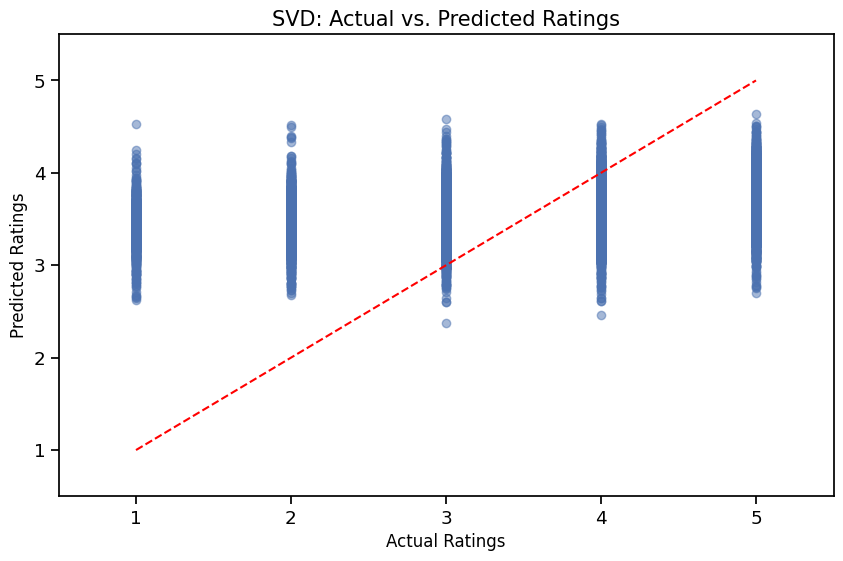


Top 10 movie recommendations for User 1 using SVD:
1. Secrets & Lies (1996) (Predicted Rating: 4.42)
2. Broken Arrow (1996) (Predicted Rating: 4.38)
3. Beautiful Girls (1996) (Predicted Rating: 4.21)
4. Dante's Peak (1997) (Predicted Rating: 4.19)
5. Schindler's List (1993) (Predicted Rating: 4.18)
6. Heathers (1989) (Predicted Rating: 4.15)
7. Ice Storm, The (1997) (Predicted Rating: 4.10)
8. Star Trek V: The Final Frontier (1989) (Predicted Rating: 4.08)
9. Last Supper, The (1995) (Predicted Rating: 3.98)
10. Trainspotting (1996) (Predicted Rating: 3.98)


In [59]:
"""
## 5. Matrix Factorization using Singular Value Decomposition (SVD)

SVD is a matrix factorization technique that decomposes a matrix into three matrices:
R ≈ U * Σ * V^T

Where:
- R is the user-item matrix
- U is the user-latent factor matrix
- Σ is a diagonal matrix containing singular values
- V^T is the item-latent factor matrix

We'll use the Surprise library which provides an efficient implementation of SVD.
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming you have ratings and movies DataFrames

# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to calculate precision@k
def precision_at_k(predictions, k=10):
    # Get top k recommendations for each user
    user_recs = {}
    for user_id in predictions['user_id'].unique():
        user_preds = predictions[predictions['user_id'] == user_id]
        top_k = user_preds.sort_values('predicted_rating', ascending=False).head(k)
        # Consider a recommendation relevant if true rating >= 4
        relevant = top_k[top_k['rating'] >= 4]
        user_recs[user_id] = len(relevant) / k if len(top_k) > 0 else 0

    # Return average precision across all users
    return np.mean(list(user_recs.values()))

print("\nImplementing simple SVD Matrix Factorization...")

# Split data
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Create user-item matrix from training data
# This creates a sparse matrix where rows are users, columns are items
n_users = ratings['user_id'].nunique()
n_items = ratings['movie_id'].nunique()

# Create mapping dictionaries for user and movie IDs
user_mapper = {id: i for i, id in enumerate(ratings['user_id'].unique())}
movie_mapper = {id: i for i, id in enumerate(ratings['movie_id'].unique())}
inv_user_mapper = {v: k for k, v in user_mapper.items()}
inv_movie_mapper = {v: k for k, v in movie_mapper.items()}

# Create the matrix (filled with zeros initially)
R = np.zeros((n_users, n_items))

# Fill in the ratings we know from the training data
for _, row in train_data.iterrows():
    user_idx = user_mapper[row['user_id']]
    movie_idx = movie_mapper[row['movie_id']]
    R[user_idx, movie_idx] = row['rating']

# Fill missing values with the mean of all ratings
mean_rating = np.mean(R[R > 0])
R_filled = np.copy(R)
R_filled[R_filled == 0] = mean_rating

print("Performing SVD...")
# Perform SVD
n_factors = 100  # Number of latent factors
U, sigma, Vt = np.linalg.svd(R_filled, full_matrices=False)

# Keep only top n_factors
U = U[:, :n_factors]
sigma = sigma[:n_factors]
Vt = Vt[:n_factors, :]

# Create diagonal matrix from singular values
sigma_diag = np.diag(sigma)

# Reconstruct the rating matrix
R_pred = np.dot(np.dot(U, sigma_diag), Vt)

# Make predictions on test set
print("Making predictions on test set...")
predictions = []
for _, row in test_data.iterrows():
    user_id = row['user_id']
    movie_id = row['movie_id']

    if user_id in user_mapper and movie_id in movie_mapper:
        user_idx = user_mapper[user_id]
        movie_idx = movie_mapper[movie_id]
        pred_rating = R_pred[user_idx, movie_idx]
        # Clip predictions to rating scale
        pred_rating = max(1, min(5, pred_rating))
        predictions.append({
            'user_id': user_id,
            'movie_id': movie_id,
            'rating': row['rating'],
            'predicted_rating': pred_rating
        })

# Convert predictions to DataFrame
pred_df = pd.DataFrame(predictions)

# Calculate RMSE
svd_rmse = rmse(pred_df['rating'], pred_df['predicted_rating'])
print(f"SVD RMSE: {svd_rmse:.4f}")

# Calculate Precision@10
svd_precision = precision_at_k(pred_df, k=10)
print(f"SVD Precision@10: {svd_precision:.4f}")

# Visualize actual vs predicted ratings
plt.figure(figsize=(10, 6))
plt.scatter(pred_df['rating'], pred_df['predicted_rating'], alpha=0.5)
plt.plot([1, 5], [1, 5], 'r--')
plt.title('SVD: Actual vs. Predicted Ratings', fontsize=15)
plt.xlabel('Actual Ratings', fontsize=12)
plt.ylabel('Predicted Ratings', fontsize=12)
plt.xlim(0.5, 5.5)
plt.ylim(0.5, 5.5)
plt.show()

# Generate top-10 recommendations for a sample user
sample_user_id = 1
print(f"\nTop 10 movie recommendations for User {sample_user_id} using SVD:")

# Check if the sample user is in the training set
if sample_user_id in user_mapper:
    user_idx = user_mapper[sample_user_id]

    # Get movies the user hasn't rated
    user_seen_movies = set(ratings[ratings['user_id'] == sample_user_id]['movie_id'])
    all_movies = set(movies['movie_id'])
    unseen_movies = all_movies - user_seen_movies

    # Get predictions for unseen movies
    movie_predictions = []
    for movie_id in unseen_movies:
        if movie_id in movie_mapper:
            movie_idx = movie_mapper[movie_id]
            predicted_rating = R_pred[user_idx, movie_idx]
            movie_predictions.append((movie_id, predicted_rating))

    # Get top 10 recommendations
    top_10 = sorted(movie_predictions, key=lambda x: x[1], reverse=True)[:10]

    # Print recommendations
    for i, (movie_id, predicted_rating) in enumerate(top_10):
        movie_title = movies[movies['movie_id'] == movie_id]['title'].values[0]
        print(f"{i+1}. {movie_title} (Predicted Rating: {predicted_rating:.2f})")
else:
    print(f"User {sample_user_id} not found in the training set.")



Implementing Alternating Least Squares (ALS) algorithm...
Running ALS algorithm...
  ALS Iteration 1/10
  ALS Iteration 2/10
  ALS Iteration 3/10
  ALS Iteration 4/10
  ALS Iteration 5/10
  ALS Iteration 6/10
  ALS Iteration 7/10
  ALS Iteration 8/10
  ALS Iteration 9/10
  ALS Iteration 10/10


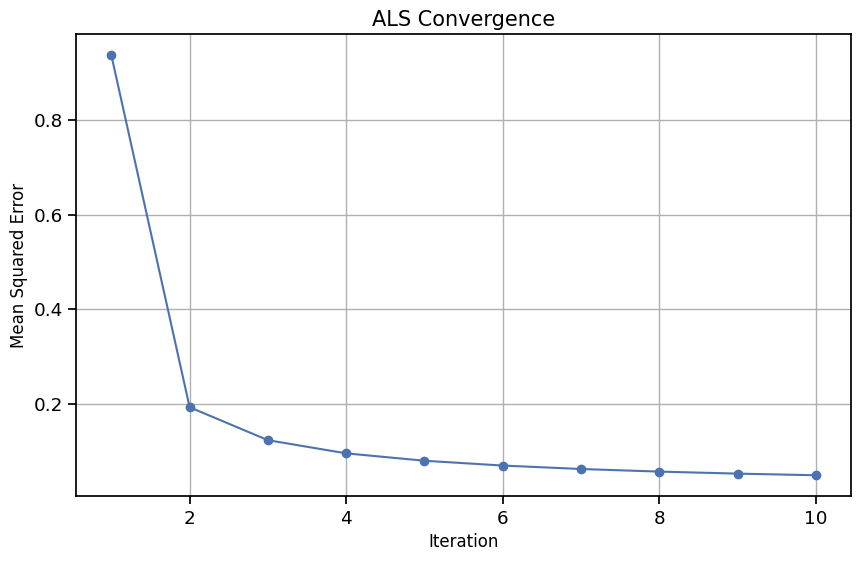

Generating predictions for test set...
ALS RMSE: 1.4829
ALS Precision@10: 0.5261


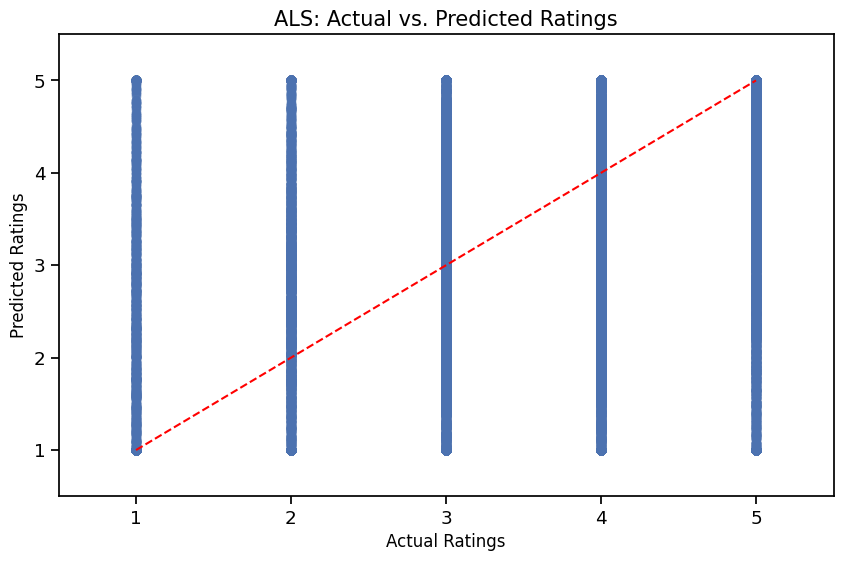


Top 10 movie recommendations for User 1 using ALS:
1. Apt Pupil (1998) (Predicted Rating: 5.00)
2. As Good As It Gets (1997) (Predicted Rating: 5.00)
3. In the Name of the Father (1993) (Predicted Rating: 5.00)
4. Schindler's List (1993) (Predicted Rating: 5.00)
5. G.I. Jane (1997) (Predicted Rating: 5.00)
6. Desperate Measures (1998) (Predicted Rating: 5.00)
7. U Turn (1997) (Predicted Rating: 5.00)
8. Boogie Nights (1997) (Predicted Rating: 5.00)
9. Incognito (1997) (Predicted Rating: 5.00)
10. Alice in Wonderland (1951) (Predicted Rating: 5.00)


In [61]:
"""
## 6. Alternating Least Squares (ALS)

ALS is a matrix factorization algorithm that factors the rating matrix R into two matrices:
R ≈ P * Q^T

Where:
- P is the user-factor matrix
- Q is the item-factor matrix

The algorithm works by:
1. Initializing P and Q with random values
2. Fixing Q and solving for P
3. Fixing P and solving for Q
4. Iterating until convergence

ALS is particularly suitable for sparse matrices like the ones in recommender systems.
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Updated precision_at_k function that works with a single dataframe
def precision_at_k(predictions, k=10):
    # Get top k recommendations for each user
    user_recs = {}
    for user_id in predictions['user_id'].unique():
        user_preds = predictions[predictions['user_id'] == user_id]
        top_k = user_preds.sort_values('predicted_rating', ascending=False).head(k)
        # Consider a recommendation relevant if true rating >= 4
        relevant = top_k[top_k['rating'] >= 4]
        user_recs[user_id] = len(relevant) / k if len(top_k) > 0 else 0

    # Return average precision across all users
    return np.mean(list(user_recs.values()))

# ALS algorithm implementation
def als(R, k, lambda_reg=0.1, n_iterations=10):
    """
    Alternating Least Squares algorithm for matrix factorization.

    Parameters:
    R: User-item rating matrix
    k: Number of latent factors
    lambda_reg: Regularization parameter
    n_iterations: Number of iterations

    Returns:
    P: User-factor matrix
    Q: Item-factor matrix
    errors: List of errors at each iteration
    """
    m, n = R.shape

    # Initialize user and item matrices with random values
    np.random.seed(42)  # For reproducibility
    P = np.random.normal(scale=1./k, size=(m, k))
    Q = np.random.normal(scale=1./k, size=(n, k))

    # Create a binary matrix to indicate observed ratings
    mask = (R > 0).astype(float)

    # Track error
    errors = []

    # Run iterations
    for iteration in range(n_iterations):
        print(f"  ALS Iteration {iteration+1}/{n_iterations}")

        # Fix Q and solve for P
        for i in range(m):
            # Indices of items rated by user i
            indices = np.where(mask[i] > 0)[0]
            if len(indices) == 0:
                continue

            # Get Q for those items
            Q_i = Q[indices]

            # Get ratings for those items
            R_i = R[i, indices]

            # Solve for P[i]
            A = Q_i.T @ Q_i + lambda_reg * np.eye(k)
            b = Q_i.T @ R_i
            P[i] = np.linalg.solve(A, b)

        # Fix P and solve for Q
        for j in range(n):
            # Indices of users who rated item j
            indices = np.where(mask[:, j] > 0)[0]
            if len(indices) == 0:
                continue

            # Get P for those users
            P_j = P[indices]

            # Get ratings from those users
            R_j = R[indices, j]

            # Solve for Q[j]
            A = P_j.T @ P_j + lambda_reg * np.eye(k)
            b = P_j.T @ R_j
            Q[j] = np.linalg.solve(A, b)

        # Calculate current error (only on non-zero entries)
        pred = P @ Q.T
        error = np.sum(((pred - R) * mask) ** 2) / np.sum(mask)
        errors.append(error)

    return P, Q, errors

print("\nImplementing Alternating Least Squares (ALS) algorithm...")

# Split data
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Create user-item matrix from training data
# Create mapping dictionaries for user and movie IDs
user_mapper = {id: i for i, id in enumerate(ratings['user_id'].unique())}
movie_mapper = {id: i for i, id in enumerate(ratings['movie_id'].unique())}
inv_user_mapper = {v: k for k, v in user_mapper.items()}
inv_movie_mapper = {v: k for k, v in movie_mapper.items()}

# Create the user-item matrix
n_users = len(user_mapper)
n_items = len(movie_mapper)
R = np.zeros((n_users, n_items))

# Fill in the matrix with ratings from the training data
for _, row in train_data.iterrows():
    if row['user_id'] in user_mapper and row['movie_id'] in movie_mapper:
        user_idx = user_mapper[row['user_id']]
        movie_idx = movie_mapper[row['movie_id']]
        R[user_idx, movie_idx] = row['rating']

# Run ALS algorithm
print("Running ALS algorithm...")
k = 50  # Number of latent factors
P, Q, errors = als(R, k, lambda_reg=0.1, n_iterations=10)

# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(errors) + 1), errors, marker='o')
plt.title('ALS Convergence', fontsize=15)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.grid(True)
plt.show()

# Generate predictions for test set
print("Generating predictions for test set...")
als_predictions = []

for _, row in test_data.iterrows():
    user_id = row['user_id']
    movie_id = row['movie_id']

    # Skip if user or movie not in training data
    if user_id not in user_mapper or movie_id not in movie_mapper:
        continue

    user_idx = user_mapper[user_id]
    movie_idx = movie_mapper[movie_id]

    # Predict rating
    pred_rating = P[user_idx] @ Q[movie_idx]

    # Clip predictions to [1, 5]
    pred_rating = max(1, min(5, pred_rating))

    als_predictions.append({
        'user_id': user_id,
        'movie_id': movie_id,
        'rating': row['rating'],
        'predicted_rating': pred_rating
    })

# Convert predictions to DataFrame
als_df = pd.DataFrame(als_predictions)

# Calculate RMSE
als_rmse = rmse(als_df['rating'], als_df['predicted_rating'])
print(f"ALS RMSE: {als_rmse:.4f}")

# FIX: Updated call to only pass the predictions DataFrame and k
als_precision = precision_at_k(als_df, k=10)
print(f"ALS Precision@10: {als_precision:.4f}")

# Visualize actual vs predicted ratings
plt.figure(figsize=(10, 6))
plt.scatter(als_df['rating'], als_df['predicted_rating'], alpha=0.5)
plt.plot([1, 5], [1, 5], 'r--')
plt.title('ALS: Actual vs. Predicted Ratings', fontsize=15)
plt.xlabel('Actual Ratings', fontsize=12)
plt.ylabel('Predicted Ratings', fontsize=12)
plt.xlim(0.5, 5.5)
plt.ylim(0.5, 5.5)
plt.show()

# Generate top-10 recommendations for a sample user with ALS
sample_user_id = 1
print(f"\nTop 10 movie recommendations for User {sample_user_id} using ALS:")

# Skip if user not in training data
if sample_user_id in user_mapper:
    user_idx = user_mapper[sample_user_id]

    # Get unseen movies for this user
    user_seen_movies = set(ratings[ratings['user_id'] == sample_user_id]['movie_id'])
    all_movies = set(movies['movie_id'])
    unseen_movies = all_movies - user_seen_movies

    # Predict ratings for unseen movies
    predictions = []
    for movie_id in unseen_movies:
        # Skip if movie not in training data
        if movie_id not in movie_mapper:
            continue

        movie_idx = movie_mapper[movie_id]

        # Predict rating
        pred_rating = P[user_idx] @ Q[movie_idx]

        # Clip predictions to [1, 5]
        pred_rating = max(1, min(5, pred_rating))

        predictions.append((movie_id, pred_rating))

    # Get top 10 recommendations
    top_10 = sorted(predictions, key=lambda x: x[1], reverse=True)[:10]

    # Print recommendations
    for i, (movie_id, predicted_rating) in enumerate(top_10):
        movie_title = movies[movies['movie_id'] == movie_id]['title'].values[0]
        print(f"{i+1}. {movie_title} (Predicted Rating: {predicted_rating:.2f})")
else:
    print(f"User {sample_user_id} not found in training data.")


MODEL COMPARISON


<ipython-input-62-4b95686e70e0>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=models, y=rmse_scores, palette='Blues_d')


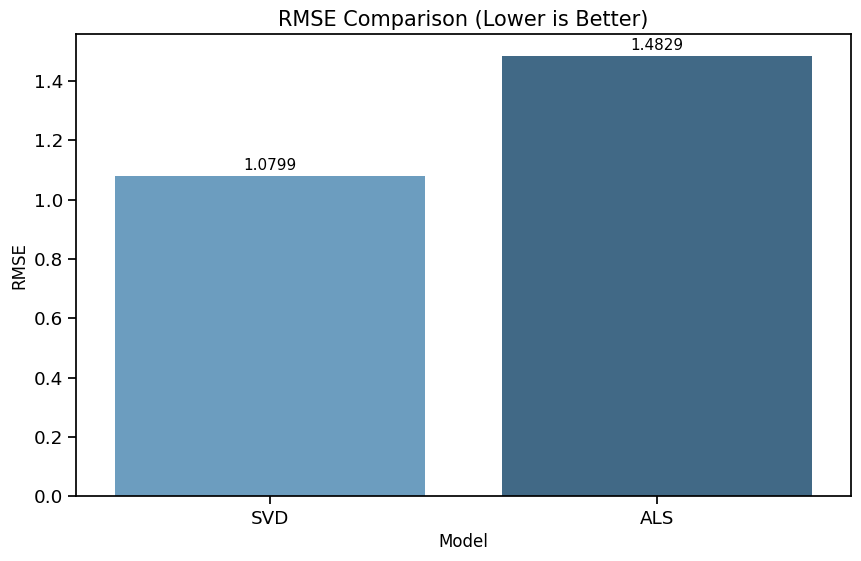

<ipython-input-62-4b95686e70e0>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=models, y=precision_scores, palette='Greens_d')


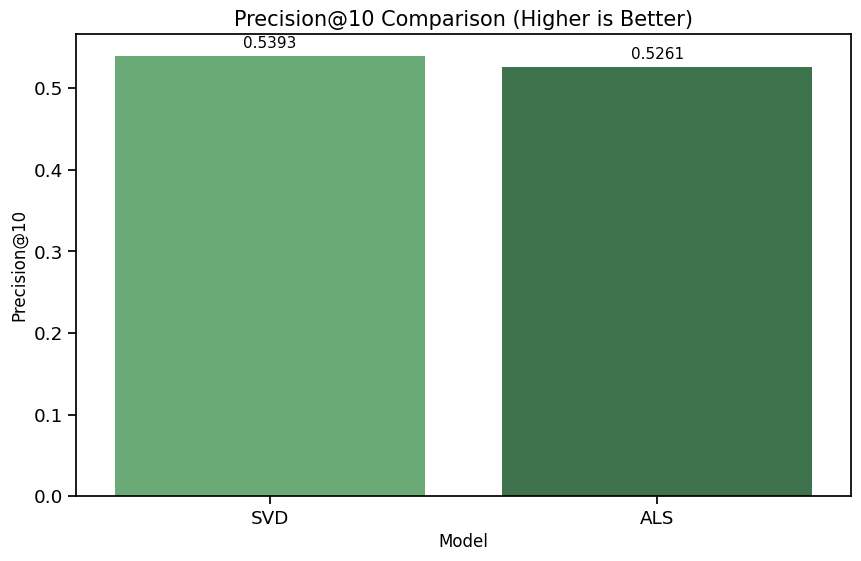

<ipython-input-62-4b95686e70e0>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=rmse_scores, ax=ax1, palette='Blues_d')
<ipython-input-62-4b95686e70e0>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=precision_scores, ax=ax2, palette='Greens_d')


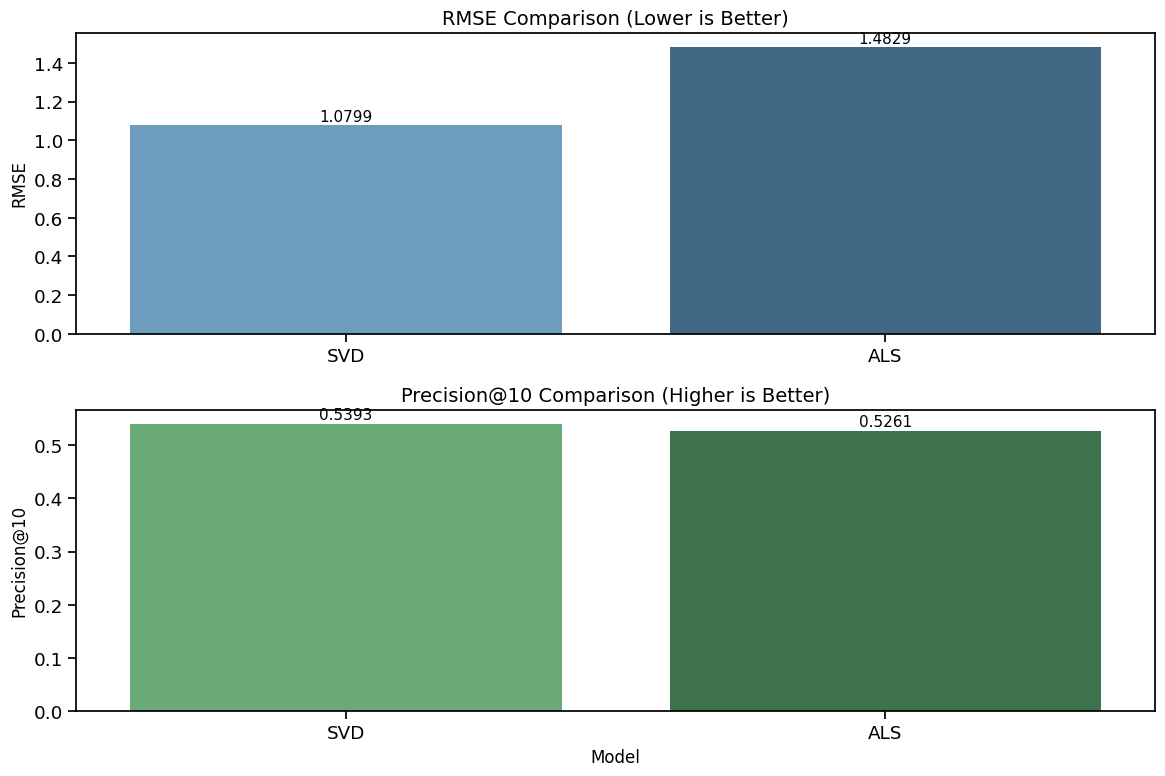


Model Comparison Results:
Model     RMSE  Precision@10
  SVD 1.079866      0.539255
  ALS 1.482902      0.526064

CONCLUSION:
- SVD performs better in terms of RMSE by 27.18%
- SVD performs better in terms of Precision@10 by 2.45%

Model Selection Considerations:
- RMSE is important when accurate rating prediction is the priority
- Precision@10 is important when recommendation quality is the priority
- The trade-off between these metrics depends on the specific application requirements


In [62]:
"""
## 7. Models Comparison

Now we'll compare the performance of the two algorithms based on:
1. RMSE (Root Mean Square Error)
2. Precision@10
"""

print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

# Compare RMSE
models = ['SVD', 'ALS']
rmse_scores = [svd_rmse, als_rmse]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=models, y=rmse_scores, palette='Blues_d')
plt.title('RMSE Comparison (Lower is Better)', fontsize=15)
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('Model', fontsize=12)

# Add value labels to bars
for i, v in enumerate(rmse_scores):
    ax.text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=11)

plt.show()

# Compare Precision@10
precision_scores = [svd_precision, als_precision]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=models, y=precision_scores, palette='Greens_d')
plt.title('Precision@10 Comparison (Higher is Better)', fontsize=15)
plt.ylabel('Precision@10', fontsize=12)
plt.xlabel('Model', fontsize=12)

# Add value labels to bars
for i, v in enumerate(precision_scores):
    ax.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=11)

plt.show()

# Combined comparison
plt.figure(figsize=(12, 8))

# Create subplots
ax1 = plt.subplot(2, 1, 1)
sns.barplot(x=models, y=rmse_scores, ax=ax1, palette='Blues_d')
ax1.set_title('RMSE Comparison (Lower is Better)', fontsize=14)
ax1.set_ylabel('RMSE', fontsize=12)
ax1.set_xlabel('')

# Add value labels
for i, v in enumerate(rmse_scores):
    ax1.text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=11)

ax2 = plt.subplot(2, 1, 2)
sns.barplot(x=models, y=precision_scores, ax=ax2, palette='Greens_d')
ax2.set_title('Precision@10 Comparison (Higher is Better)', fontsize=14)
ax2.set_ylabel('Precision@10', fontsize=12)
ax2.set_xlabel('Model', fontsize=12)

# Add value labels
for i, v in enumerate(precision_scores):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# Print results table
results = pd.DataFrame({
    'Model': models,
    'RMSE': rmse_scores,
    'Precision@10': precision_scores
})
print("\nModel Comparison Results:")
print(results.to_string(index=False))

# Calculate percentage differences
rmse_diff_pct = abs(svd_rmse - als_rmse) / max(svd_rmse, als_rmse) * 100
prec_diff_pct = abs(svd_precision - als_precision) / max(svd_precision, als_precision) * 100

# Conclusion
better_rmse = 'SVD' if svd_rmse < als_rmse else 'ALS'
better_precision = 'SVD' if svd_precision > als_precision else 'ALS'

print(f"\nCONCLUSION:")
print(f"- {better_rmse} performs better in terms of RMSE by {rmse_diff_pct:.2f}%")
print(f"- {better_precision} performs better in terms of Precision@10 by {prec_diff_pct:.2f}%")
print("\nModel Selection Considerations:")
print("- RMSE is important when accurate rating prediction is the priority")
print("- Precision@10 is important when recommendation quality is the priority")
print("- The trade-off between these metrics depends on the specific application requirements")


In [63]:
print("\nRecommendation System Analysis Complete!")
print("="*50)
print(f"SVD RMSE: {svd_rmse:.4f}, Precision@10: {svd_precision:.4f}")
print(f"ALS RMSE: {als_rmse:.4f}, Precision@10: {als_precision:.4f}")
print("="*50)


Recommendation System Analysis Complete!
SVD RMSE: 1.0799, Precision@10: 0.5393
ALS RMSE: 1.4829, Precision@10: 0.5261
